In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

plt.rcParams['figure.figsize'] = [16, 10]
%matplotlib inline

# **Read Data**

We can choose any certain person, in this case we choose MAC000322

In [47]:
df = pd.read_csv('block_10.csv', parse_dates=['day'])
df = df[df['LCLid'] == 'MAC000322']
df

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000322,2012-03-07,0.125,0.104,0.133,0.145,0.109,0.298,0.149,0.119,...,0.087,0.092,0.187,0.130,0.096,0.096,0.137,0.101,0.137,0.485
1,MAC000322,2012-03-08,0.279,0.247,0.253,0.275,0.114,0.105,0.117,0.141,...,0.105,0.132,0.252,0.105,0.096,0.129,0.120,0.070,0.039,0.074
2,MAC000322,2012-03-09,0.036,0.130,0.364,0.120,0.100,0.118,0.146,0.105,...,0.028,0.030,0.072,0.038,0.029,0.046,0.069,0.029,0.050,0.520
3,MAC000322,2012-03-10,0.435,0.093,0.105,0.138,0.099,0.096,0.133,0.129,...,0.120,0.125,0.115,0.101,0.142,0.112,0.099,0.150,0.152,0.097
4,MAC000322,2012-03-11,0.187,0.122,0.094,0.109,0.139,0.099,0.111,0.137,...,0.036,0.100,0.358,0.122,0.095,0.111,0.141,0.097,0.095,0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,MAC000322,2014-02-23,0.130,0.124,0.131,0.184,0.176,0.641,0.090,0.092,...,0.150,0.167,0.074,0.091,0.339,0.425,0.063,0.055,0.103,0.208
715,MAC000322,2014-02-24,0.220,0.120,0.113,0.115,0.130,0.075,0.074,0.213,...,0.158,0.094,0.073,0.269,0.129,0.075,0.075,0.088,0.145,0.105
716,MAC000322,2014-02-25,0.096,0.118,0.175,0.161,0.100,0.075,0.117,0.133,...,0.061,0.100,0.384,0.162,0.100,0.075,0.075,0.124,0.125,0.134
717,MAC000322,2014-02-26,0.151,0.160,0.564,0.598,0.133,0.126,0.184,0.154,...,0.011,0.011,0.093,0.074,0.102,0.118,0.127,0.062,0.028,0.037


# **Data Preprocessing**

The data has row per day, with columns of 30 min intervals, we need only one column with datetime instead of 48 columns to represent the time and another column with the energy consumption for each 30 min interval. 

In [48]:
def convert_standard_form_to_expand_time_series(standard_df, consumer_id,  verbose=False):
   # Similar to compact steps
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
  expand_df['frequency'] = '30min'
  expand_df['serie_length'] = len(expand_df)
  ## Here we resample our day column to construct a timestamp column with frequenct 30min
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  ## Drop unnecessary columns
  expand_df = expand_df.drop(columns=['day','offset'])
  expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  if verbose:
    display(expand_df)
  return expand_df

In [49]:
expanded_df = convert_standard_form_to_expand_time_series(df, 'MAC000322').drop(columns=['serie_length','frequency'])
expanded_df

,LCLid,timestamp,energy_consumption
0,MAC000322,2012-03-07 00:00:00,0.125
1,MAC000322,2012-03-07 00:30:00,0.104
2,MAC000322,2012-03-07 01:00:00,0.133
3,MAC000322,2012-03-07 01:30:00,0.145
4,MAC000322,2012-03-07 02:00:00,0.109
...,...,...,...
34507,MAC000322,2014-02-23 21:30:00,0.116
34508,MAC000322,2014-02-23 22:00:00,0.108
34509,MAC000322,2014-02-23 22:30:00,0.129
34510,MAC000322,2014-02-23 23:00:00,0.058


# **Stationarity**

## 1 - Running Sequence Plot

Let's try to find a pattern in the energy consumption over time.

In [50]:
def plot_time_series(df):
    plt.figure(figsize=(20,10))
    plt.plot(df['timestamp'], df['energy_consumption'])
    
    plt.title('Energy Consumption Over Time')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption')
    plt.grid(True)
    
    plt.xticks(rotation=45)
    plt.show()

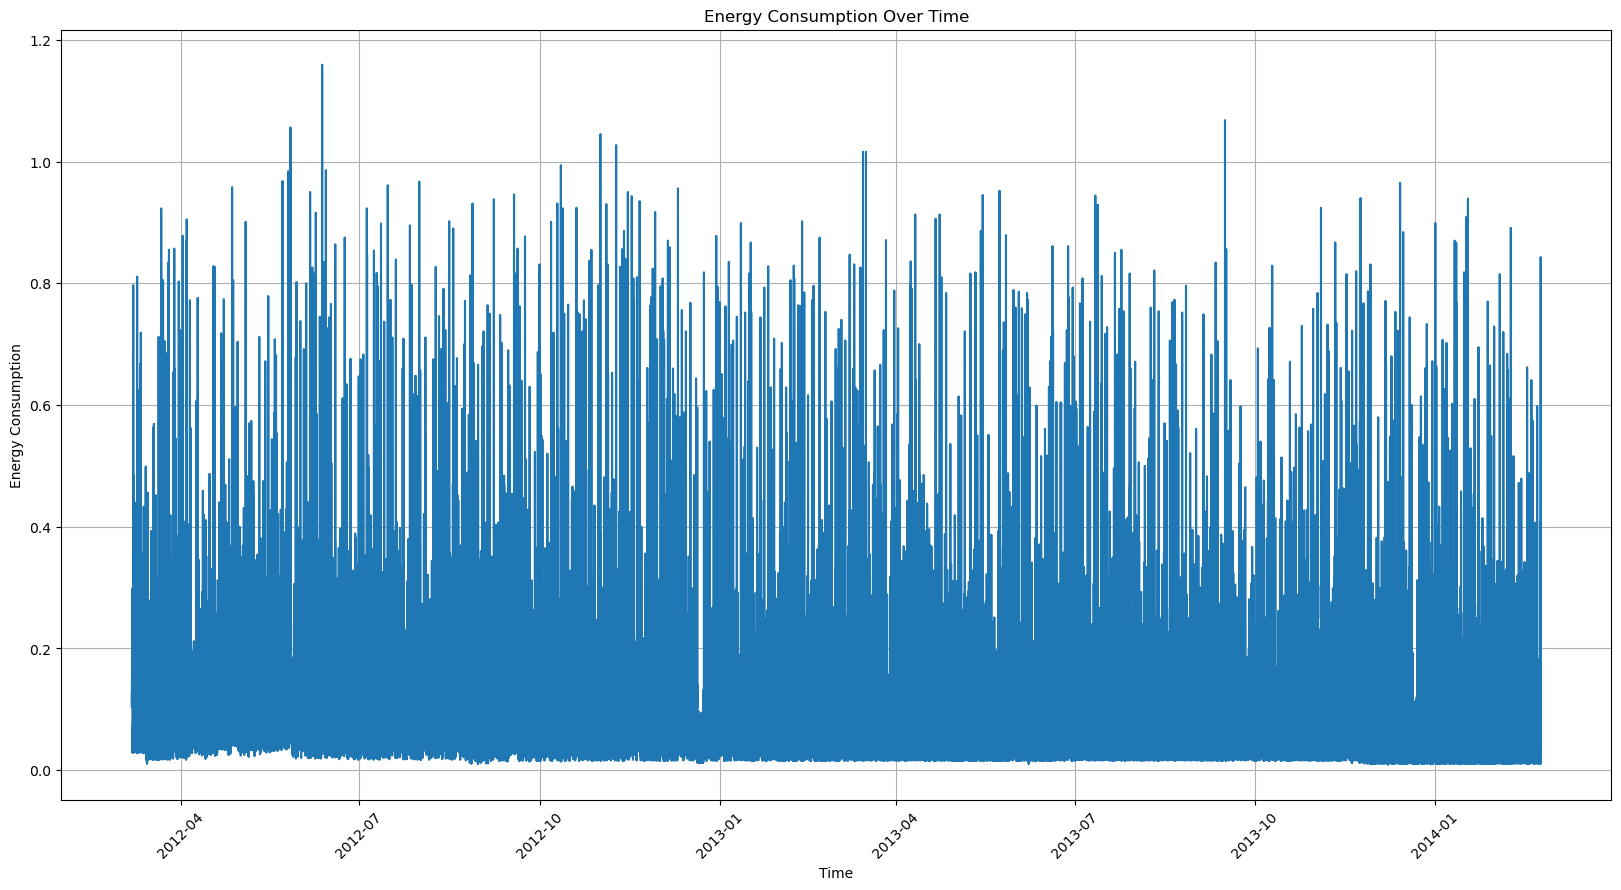

In [51]:
plot_time_series(expanded_df)

We can't see anything from this plot. The consumption is half-hourly.

Let's aggregate to make it hourly then daily then weekly then monthly. We might see some pattern after decreasing precision.

In [52]:
hourly_df = expanded_df.set_index('timestamp').groupby('LCLid').resample('H')['energy_consumption'].mean().round(3).reset_index()

In [53]:
hourly_df

,LCLid,timestamp,energy_consumption
0,MAC000322,2012-03-07 00:00:00,0.114
1,MAC000322,2012-03-07 01:00:00,0.139
2,MAC000322,2012-03-07 02:00:00,0.204
3,MAC000322,2012-03-07 03:00:00,0.134
4,MAC000322,2012-03-07 04:00:00,0.115
...,...,...,...
17251,MAC000322,2014-02-23 19:00:00,0.098
17252,MAC000322,2014-02-23 20:00:00,0.504
17253,MAC000322,2014-02-23 21:00:00,0.116
17254,MAC000322,2014-02-23 22:00:00,0.118


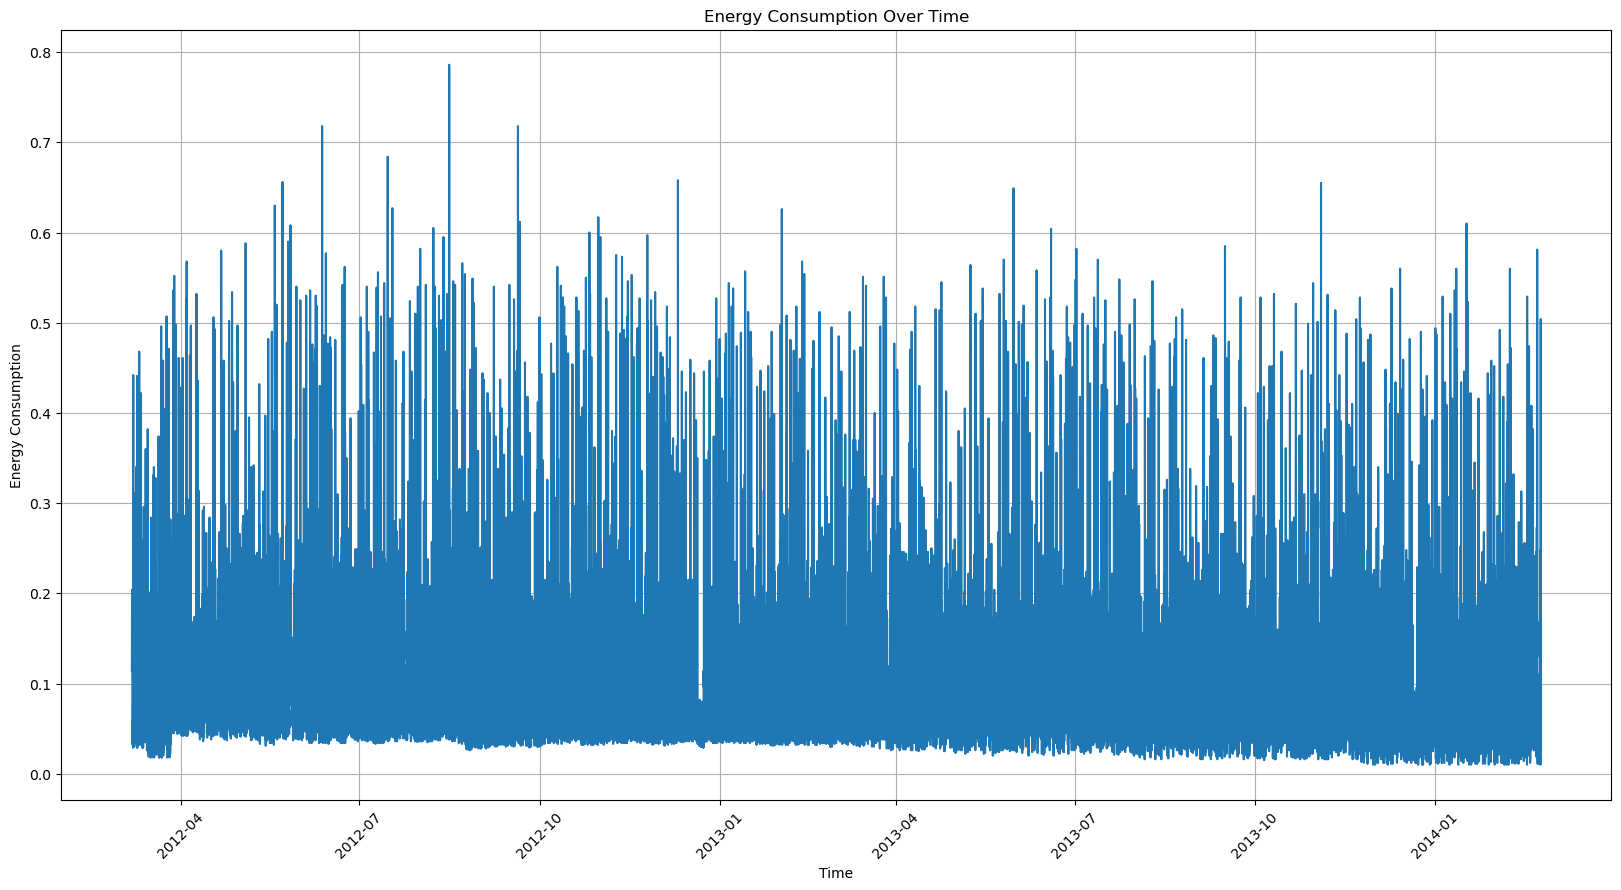

In [54]:
plot_time_series(hourly_df)

Still can't see anything due to the high precision. Let's try daily

In [55]:
daily_df = expanded_df.set_index('timestamp').groupby('LCLid').resample('D')['energy_consumption'].mean().round(3).reset_index()
daily_df

,LCLid,timestamp,energy_consumption
0,MAC000322,2012-03-07,0.115
1,MAC000322,2012-03-08,0.104
2,MAC000322,2012-03-09,0.111
3,MAC000322,2012-03-10,0.122
4,MAC000322,2012-03-11,0.121
...,...,...,...
714,MAC000322,2014-02-19,0.126
715,MAC000322,2014-02-20,0.087
716,MAC000322,2014-02-21,0.109
717,MAC000322,2014-02-22,0.092


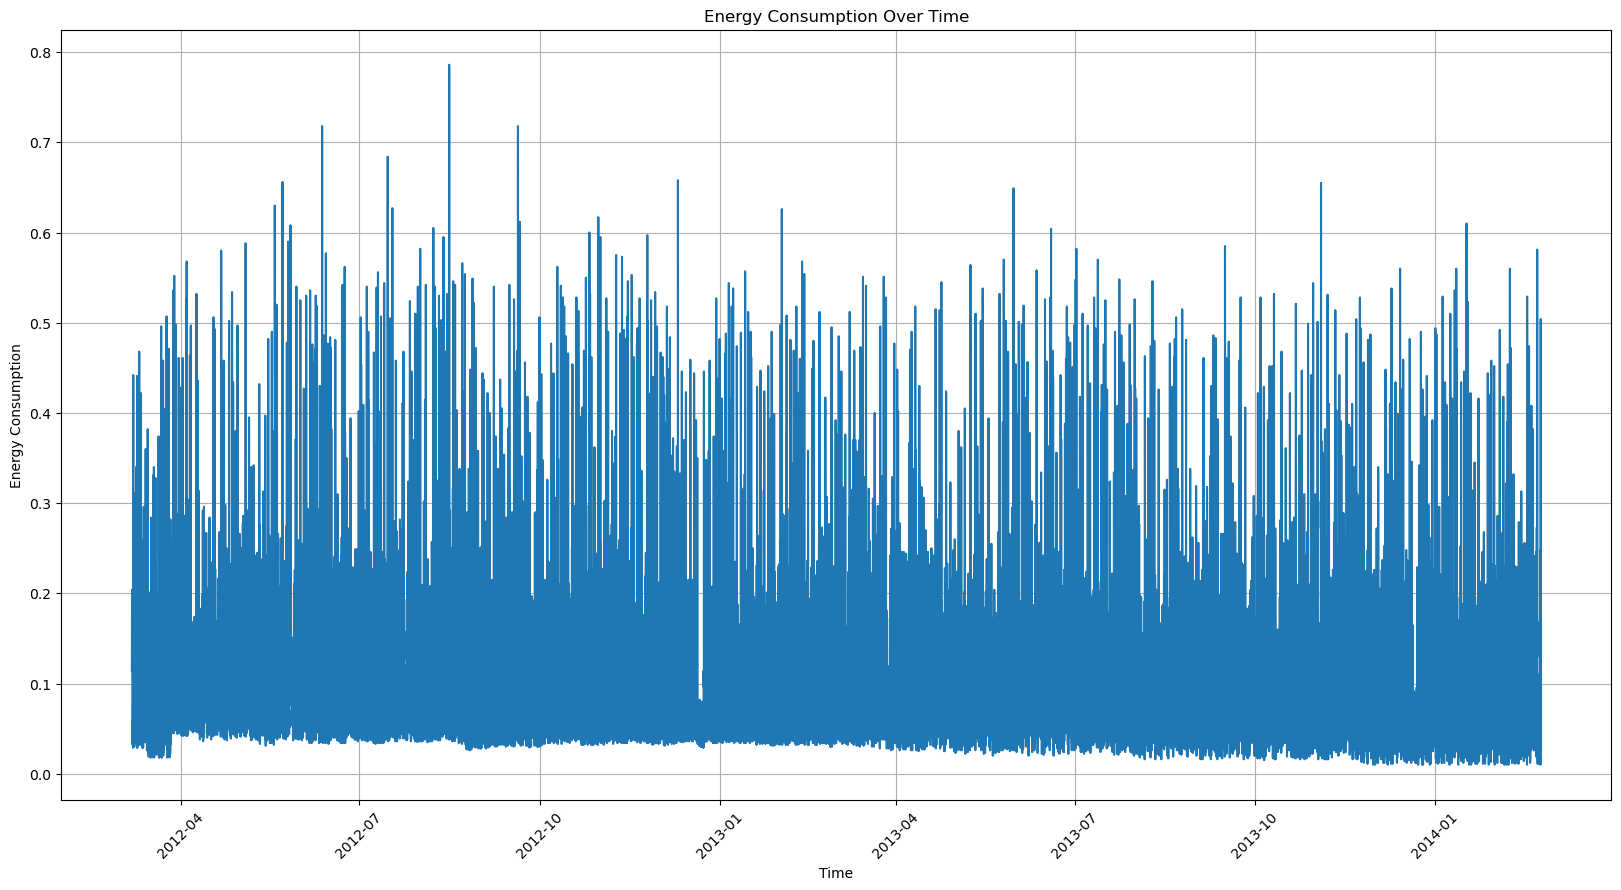

In [56]:
plot_time_series(hourly_df)

Not any better than the previous. Let's try weekly.

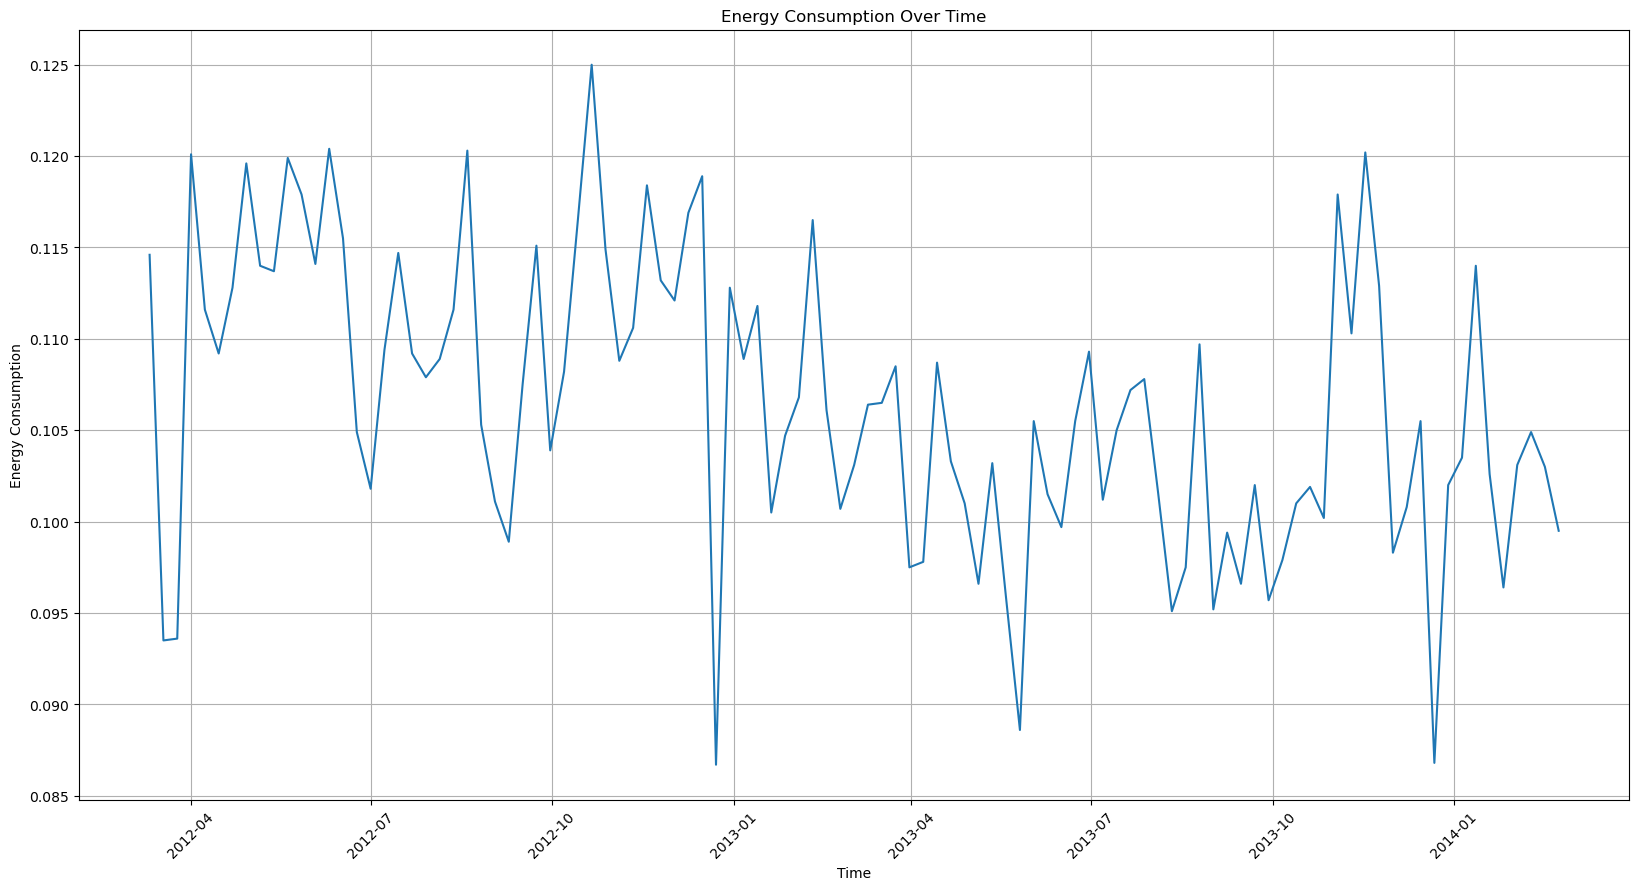

In [57]:
weekly_df = expanded_df.set_index('timestamp').groupby('LCLid').resample('W')['energy_consumption'].mean().round(4).reset_index()
plot_time_series(weekly_df)

Here we can see that the data is non-stationary, due to the abrupt changes in the mean with respect to the time. However from a domain expert's point of view, the data may be stationary because the changes may not be of a big magnitude with respect to the expert's view.
 Let's check monthly data

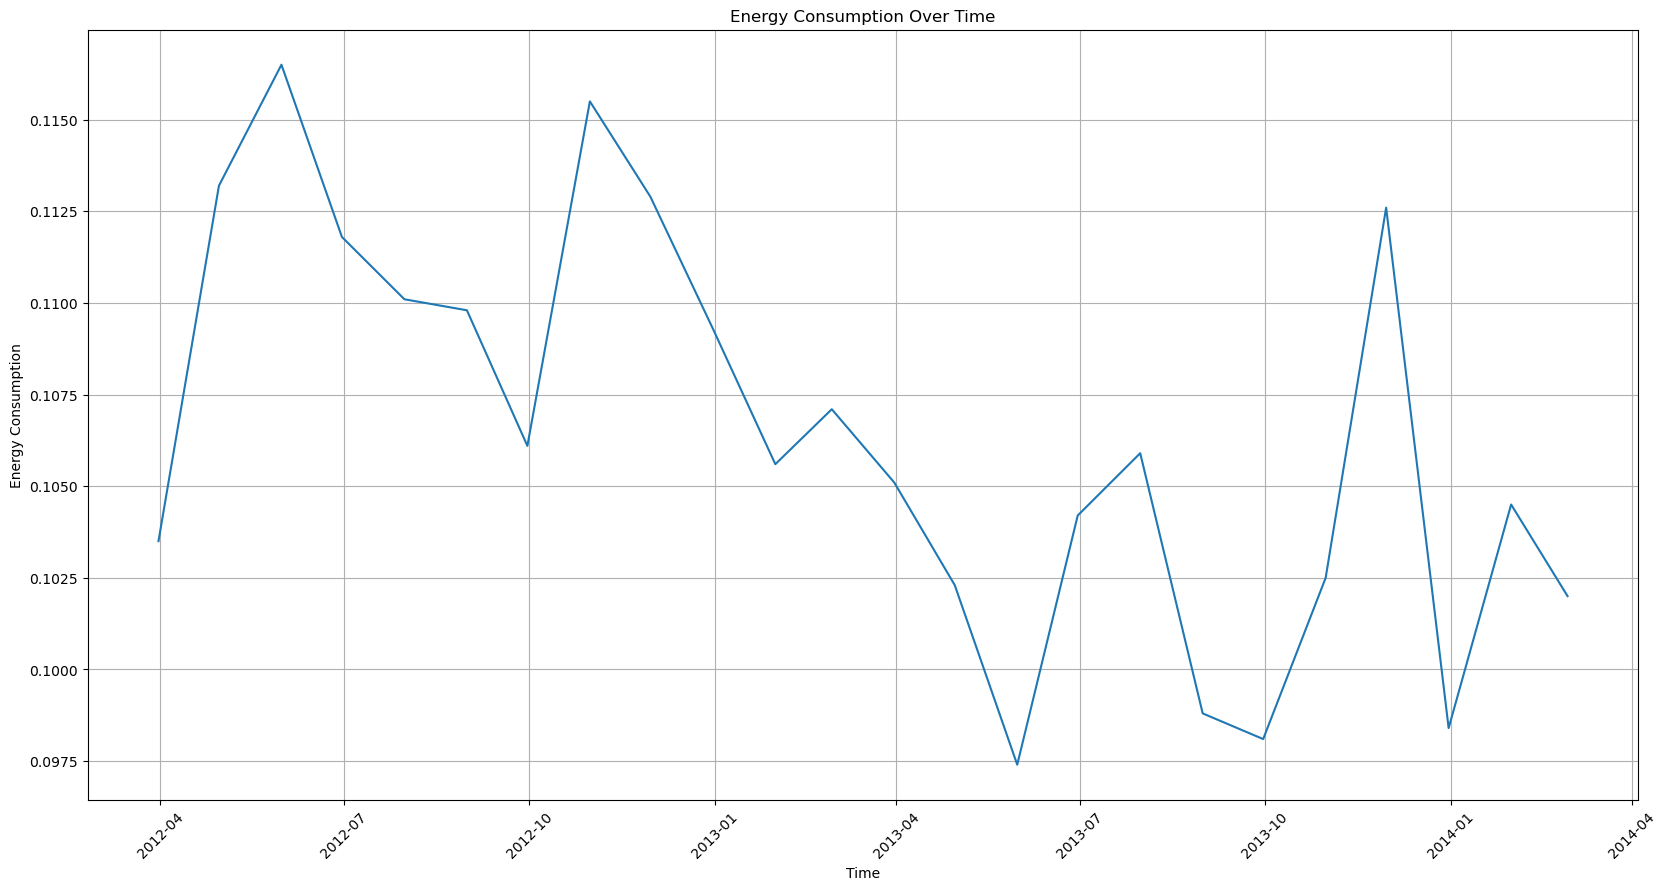

In [58]:
monthly_df = expanded_df.set_index('timestamp').groupby('LCLid').resample('M')['energy_consumption'].mean().round(4).reset_index()
plot_time_series(monthly_df)

Again, the monthly data also shows non-stationarity with random changes in the mean. The mean monthly consumption is kind of decreasing over time.

## 2 - Summary Statistics

<Axes: xlabel='energy_consumption', ylabel='Count'>

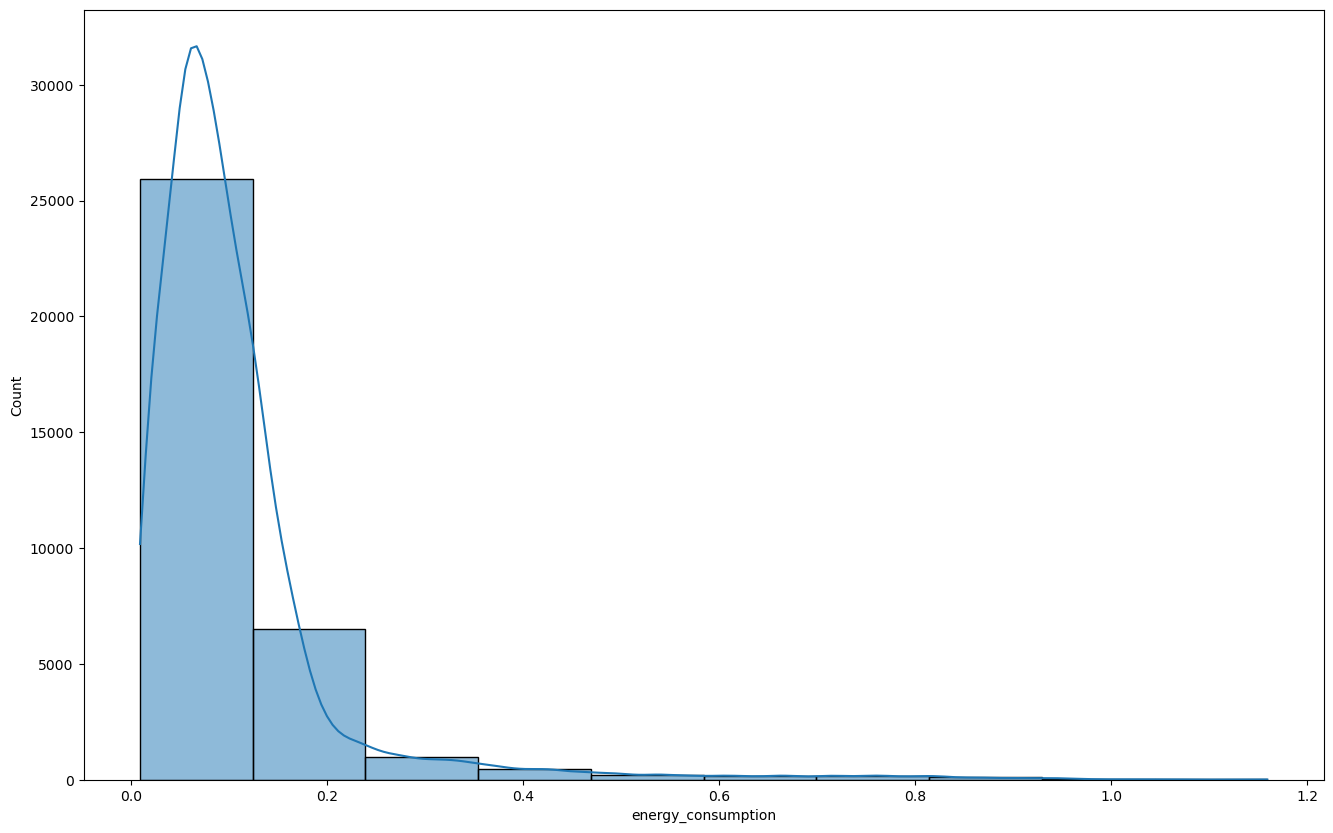

In [59]:
original_df = expanded_df.copy()
sns.histplot(original_df['energy_consumption'], bins=10, kde=True)


Left skewed histogram. The plot suggests that the data is non-stationary, however the data might be following a normal distribution, which indicates that the data might be stationary. But let's change the bins to 100 and check the plot again.

<Axes: xlabel='energy_consumption', ylabel='Count'>

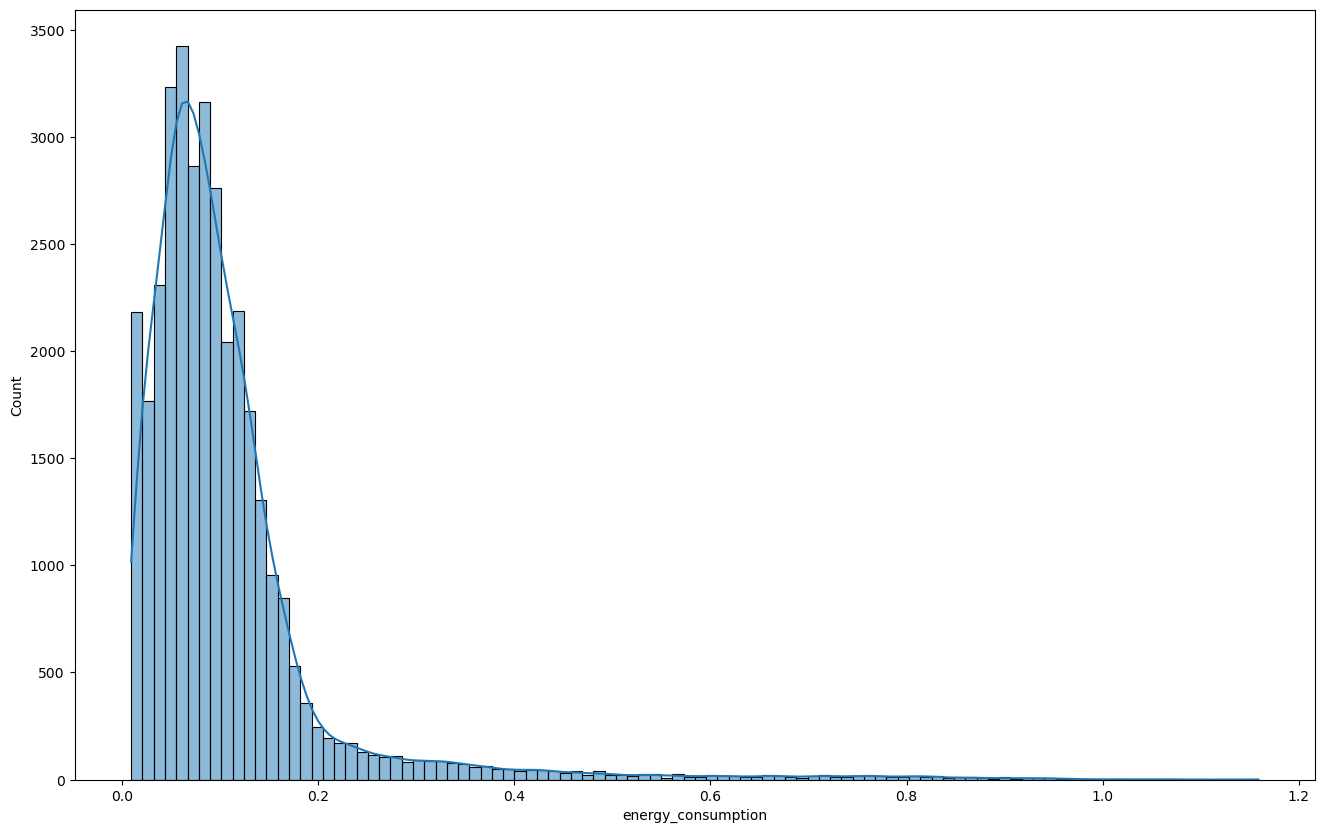

In [60]:
sns.histplot(original_df['energy_consumption'], bins=100, kde=True)

let's try 1000 bins

<Axes: xlabel='energy_consumption', ylabel='Count'>

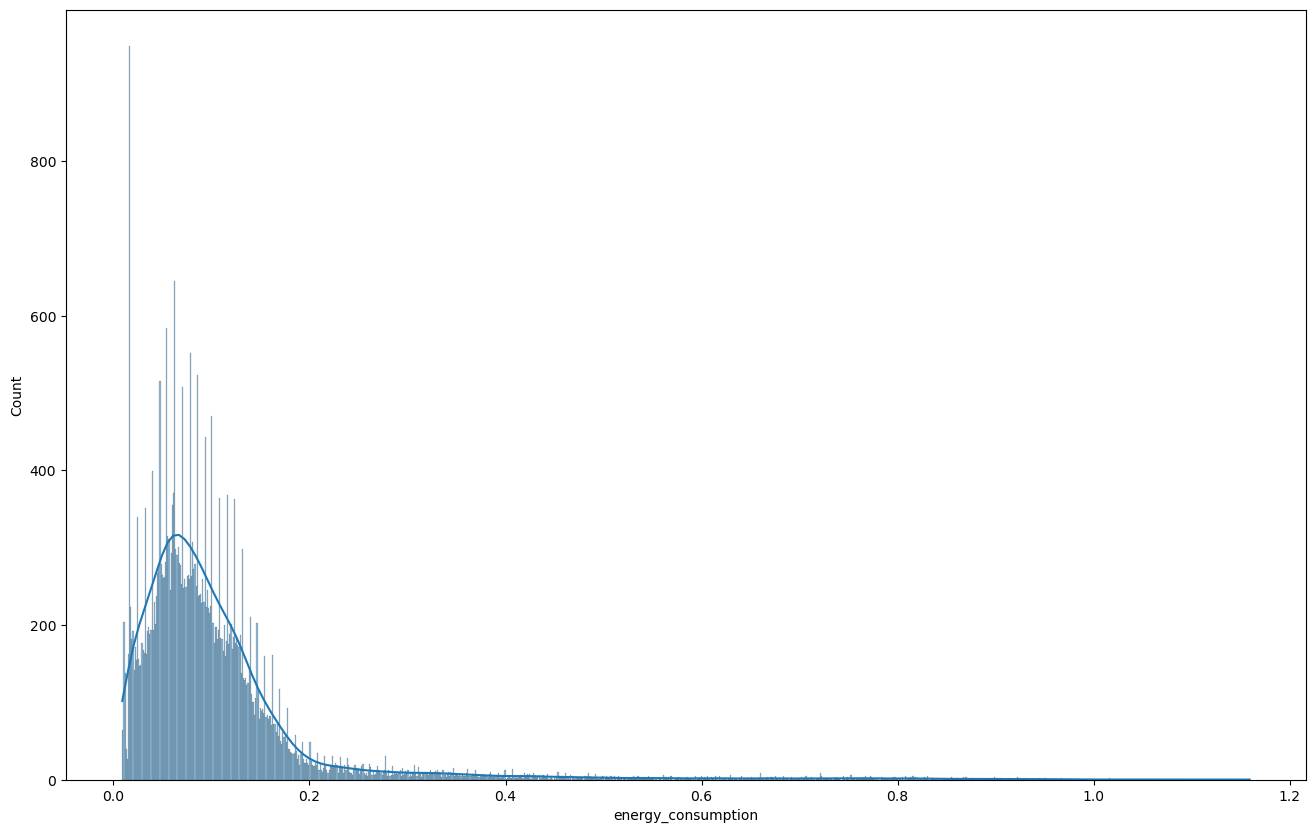

In [61]:
sns.histplot(original_df['energy_consumption'], bins=1000, kde=True)

Looks like the data is following a near normal distribution, giving a hint that the data might be stationary. This is challenging to decide on whether the data is stationary or not.

We will check the variance.

Summary Statistics for hourly data:

<Axes: xlabel='energy_consumption', ylabel='Count'>

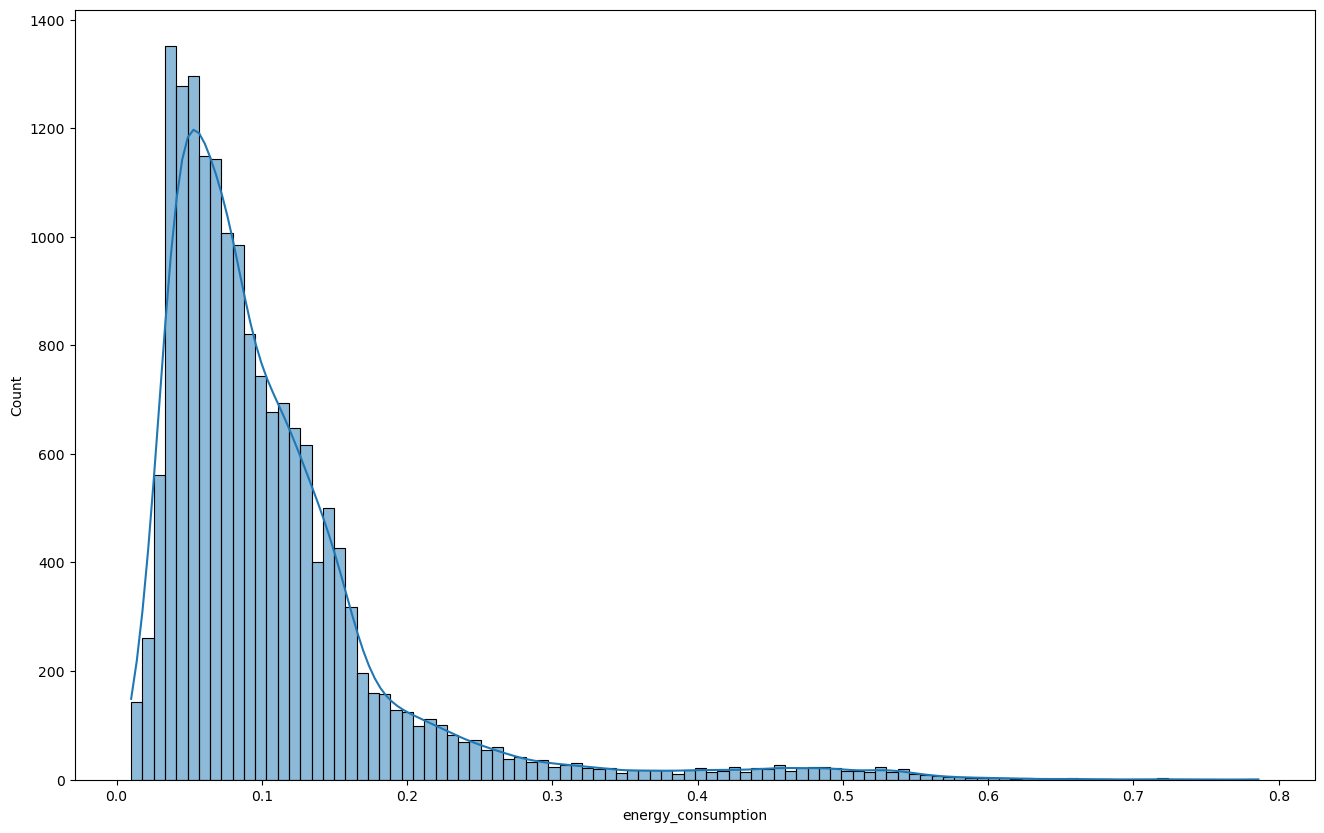

In [62]:
sns.histplot(hourly_df['energy_consumption'], bins=100, kde=True)

A near normal distribution appears in hourly data, which indicates that the data is stationary. Next, daily data:

<Axes: xlabel='energy_consumption', ylabel='Count'>

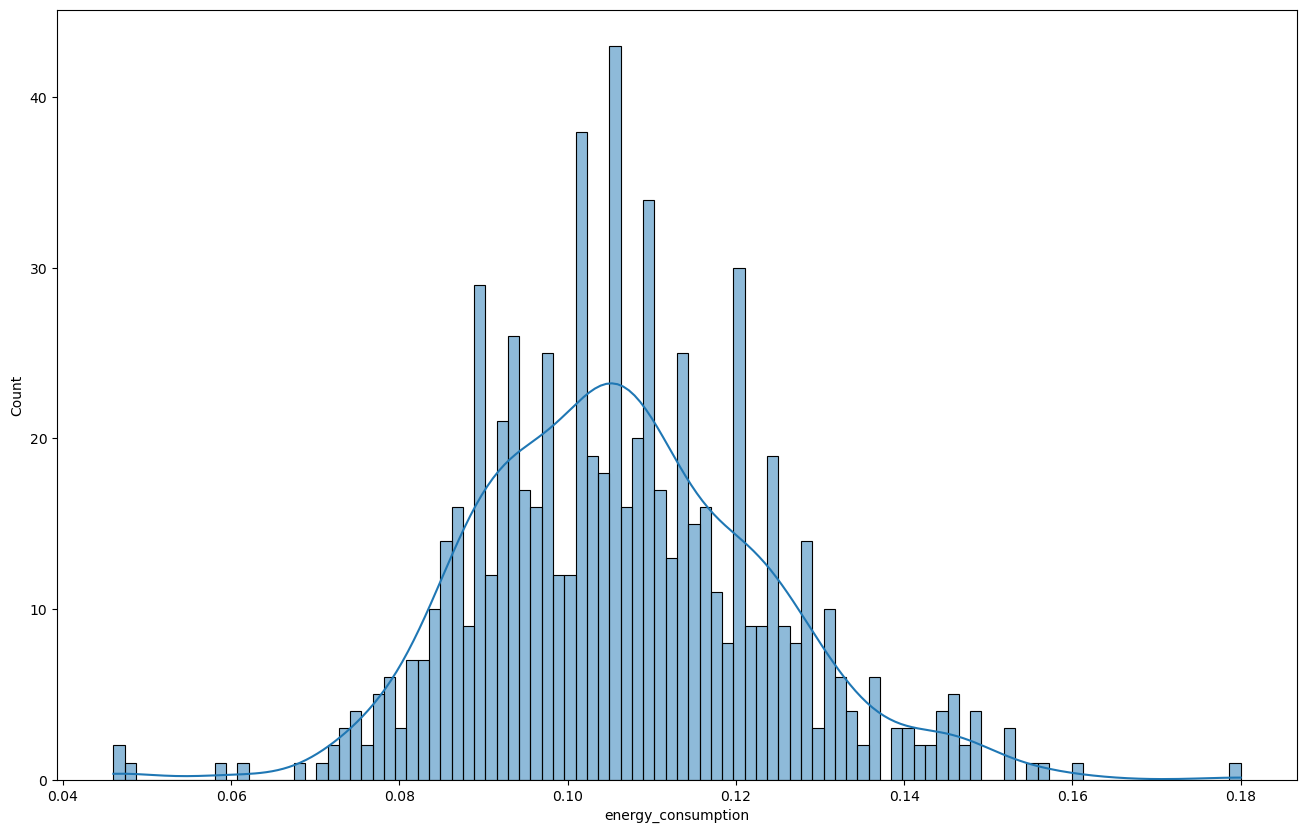

In [63]:
sns.histplot(daily_df['energy_consumption'], bins=100, kde=True)

a clear normal distribution appears in daily data, which gives a strong hint that the daily data is stationary. Next, weekly data:

<Axes: xlabel='energy_consumption', ylabel='Count'>

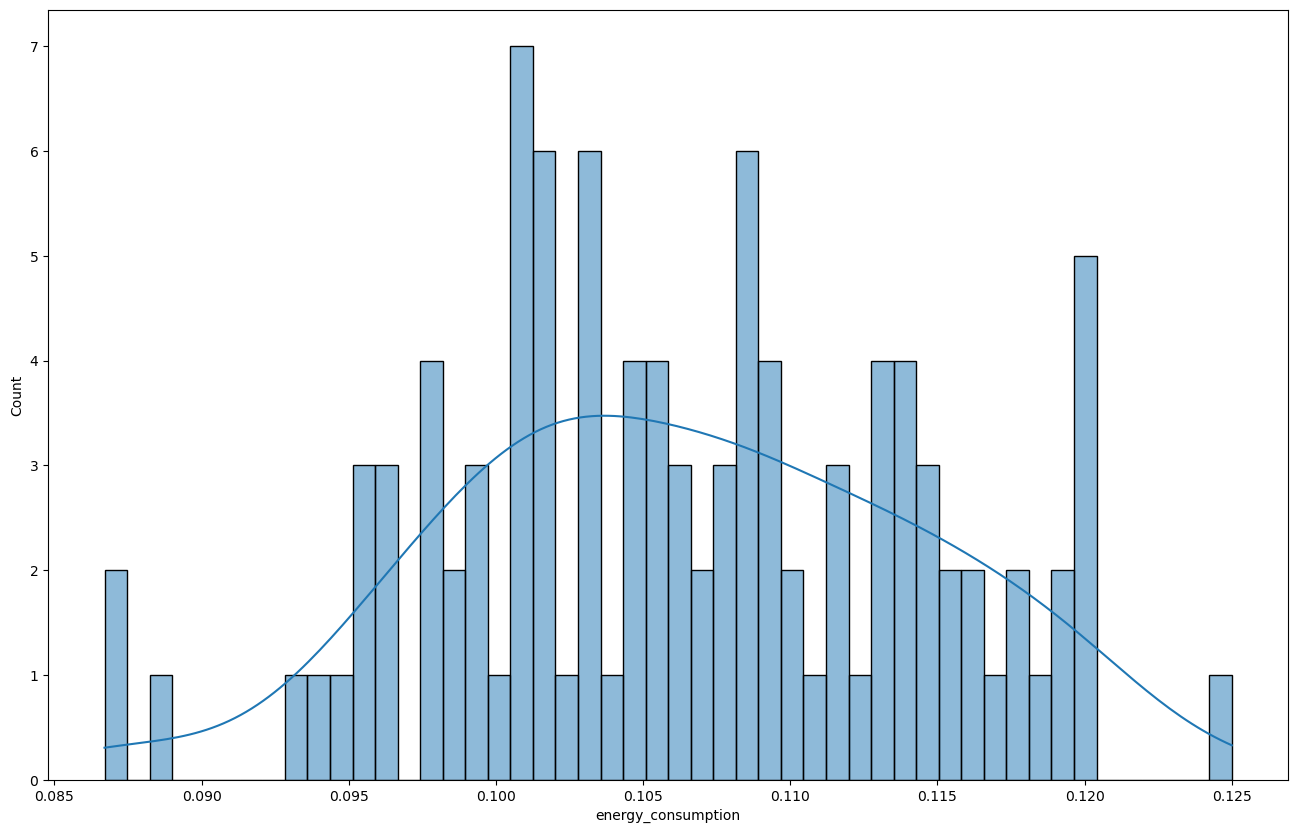

In [64]:
sns.histplot(weekly_df['energy_consumption'], bins=50, kde=True)

Not so much a normal distribution appears in weekly data we might need to check more using the upcoming tests. Next, monthly data:

<Axes: xlabel='energy_consumption', ylabel='Count'>

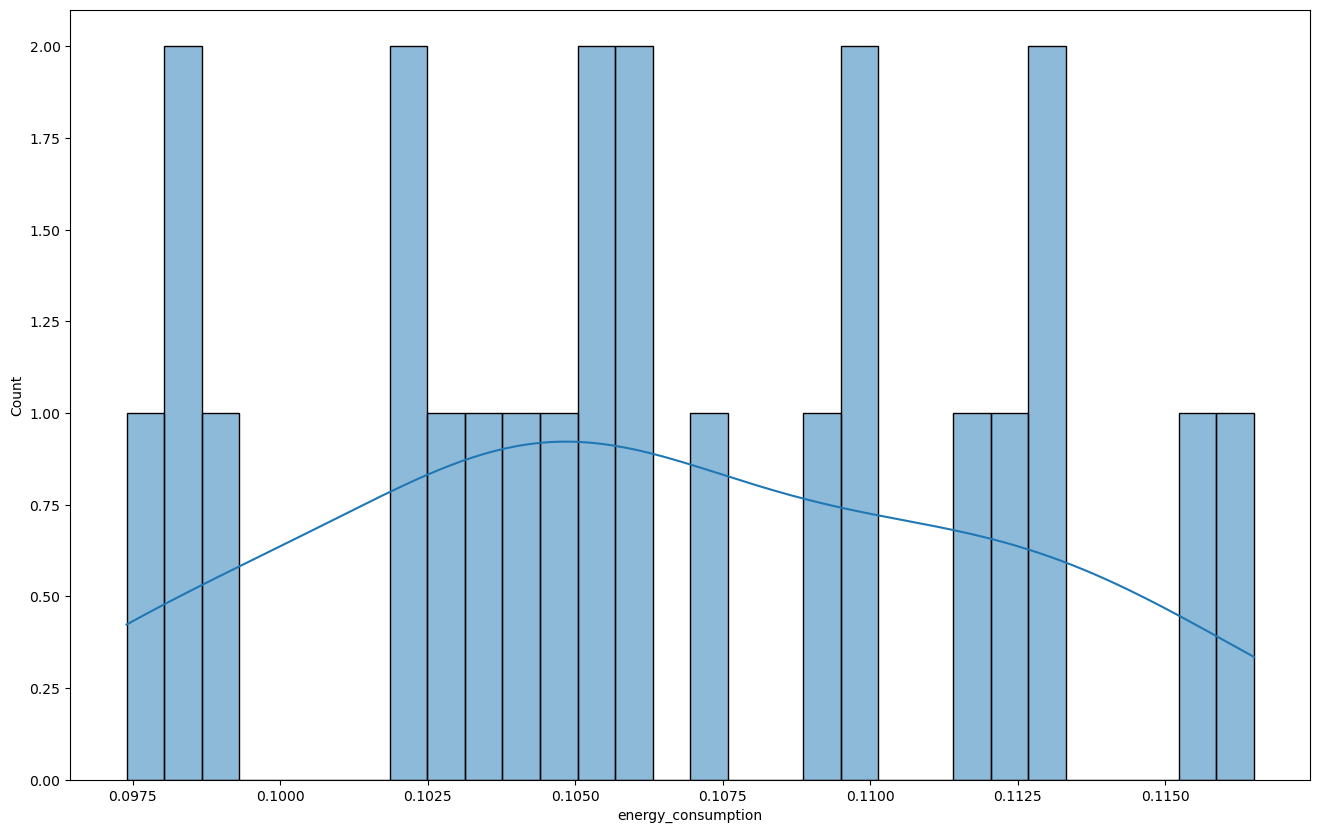

In [65]:
sns.histplot(monthly_df['energy_consumption'], bins=30, kde=True)

Here the distribution is not normal. But looks like the changes are not singificant enough to be non-stationary. Needs more checks.

Next we will all the data to chunks and look at the means and variances.

In [66]:
print(len(original_df['energy_consumption']))

34512


In [67]:
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
chunks = np.split(original_df['energy_consumption'][:34500], indices_or_sections=50)    # that was for splitting purposes
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

Chunk | Mean    | Variance
--------------------------
[0.10046232 0.11165507 0.11054348 0.11382319 0.11448986 0.11826812
 0.11717681 0.10641594 0.11215072 0.10621304 0.11288841 0.11181884
 0.10055507 0.11079855 0.10677536 0.12126957 0.11067101 0.11503913
 0.11353768        nan 0.10115652 0.10912174 0.10087971 0.11250435
 0.10283623 0.10651884 0.10284493 0.10347101 0.10229275 0.10001884
 0.09264203 0.10310725 0.10366522 0.10436377 0.10642609 0.10279565
 0.09767536 0.10182174 0.10011159 0.09532464 0.10004928 0.10551159
 0.11534348 0.1123913  0.09863478 0.09673478 0.10683333 0.10133913
 0.10440725 0.0998087 ]
[0.01024468 0.01533372 0.00787513 0.01006463 0.00915943 0.01271414
 0.01607236 0.0107204  0.01345264 0.01055853 0.01296585 0.01292562
 0.01161898 0.0144598  0.0098163  0.01416741 0.01388513 0.01549028
 0.01405767        nan 0.01062609 0.01344186 0.00789062 0.01431765
 0.008835   0.01162576 0.01004198 0.0113691  0.00875469 0.0078944
 0.0088584  0.01098053 0.0105925  0.01290112 0.01130

Chunk | Mean    | Variance
--------------------------
0 | 0.10046 | 0.01024
1 | 0.11166 | 0.01533
2 | 0.11054 | 0.00788
3 | 0.11382 | 0.01006
4 | 0.11449 | 0.00916
5 | 0.11827 | 0.01271
6 | 0.11718 | 0.01607
7 | 0.10642 | 0.01072
8 | 0.11215 | 0.01345
9 | 0.10621 | 0.01056
10 | 0.11289 | 0.01297
11 | 0.11182 | 0.01293
12 | 0.10056 | 0.01162
13 | 0.11080 | 0.01446
14 | 0.10678 | 0.00982
15 | 0.12127 | 0.01417
16 | 0.11067 | 0.01389
17 | 0.11504 | 0.01549
18 | 0.11354 | 0.01406
19 | 0.11587 | 0.01213
20 | 0.10116 | 0.01063
21 | 0.10912 | 0.01344
22 | 0.10088 | 0.00789
23 | 0.11250 | 0.01432
24 | 0.10284 | 0.00883
25 | 0.10652 | 0.01163
26 | 0.10284 | 0.01004
27 | 0.10347 | 0.01137
28 | 0.10229 | 0.00875
29 | 0.10002 | 0.00789
30 | 0.09264 | 0.00886
31 | 0.10311 | 0.01098
32 | 0.10367 | 0.01059
33 | 0.10436 | 0.01290
34 | 0.10643 | 0.01130
35 | 0.10280 | 0.01046
36 | 0.09768 | 0.00850
37 | 0.10182 | 0.00862
38 | 0.10011 | 0.01093
39 | 0.09532 | 0.00582
40 | 0.10005 | 0.00822
41 | 0.10551 

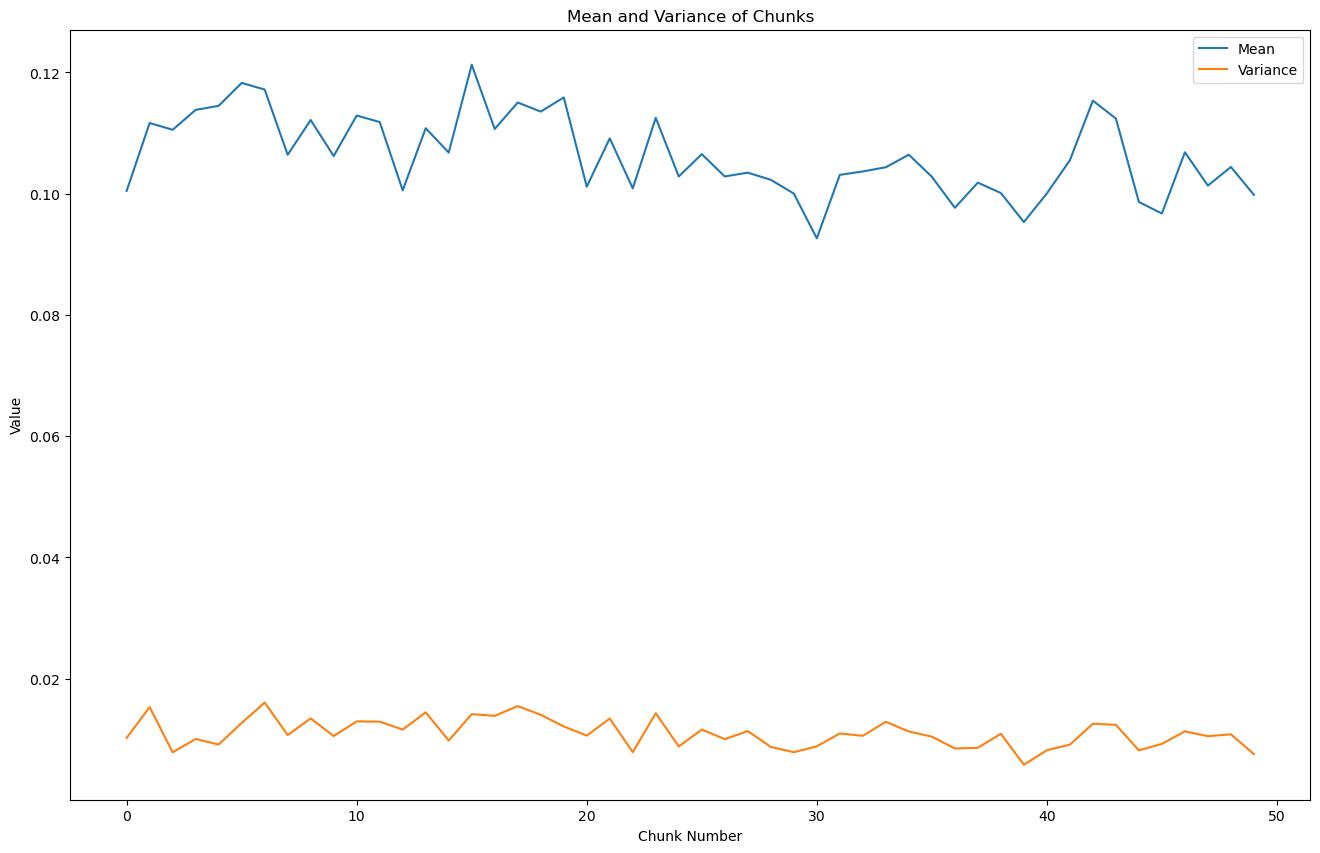

In [68]:
# using a for loop
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
means = []
variances = []
for i, chunk in enumerate(chunks):
    print(f"{i} | {np.mean(chunk):.5f} | {np.var(chunk):.5f}")
    means.append(np.mean(chunk))
    variances.append(np.var(chunk))
plt.plot(means, label='Mean')
plt.plot(variances, label='Variance')
plt.title('Mean and Variance of Chunks')
plt.xlabel('Chunk Number')
plt.ylabel('Value')
plt.legend()
plt.show()

As we can see, the variance and mean values support the indication given by the histogram that the data is stationary (although the differences in means are slightly higher than the differences in variances), which was not the case when we ran the sequence plots. We can run a normality test to check whether data means follow a normal distribution or not.

In [69]:
from scipy.stats import normaltest
normaltest_result = normaltest(means)
print(normaltest_result)
if normaltest_result.pvalue < 0.05:
    print("\nThe means are not normally distributed.")
else:   
    print("The means are normally distributed.")

NormaltestResult(statistic=2.3869486557054937, pvalue=0.30316613365142336)
The means are normally distributed.


Interestingly enough, the means are normally distributed. I don't know if this is a good indication that the data is stationary or not. We need more scientific tests to check whether the data is stationary or not. Let's try the Dickey-Fuller test

## 3 - Augmented Dickey-Fuller Test (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Null Hypothesis: The time series is non-stationary.

Alternative Hypothesis: The time series is stationary.

First: the hourly data

In [70]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_df['energy_consumption'])
print(f"ADF Statistic: {adf}")
print(f"p-value: {pvalue}")
print(f"Critical Values: {critical_values}")

ADF Statistic: -22.661917632046368
p-value: 0.0
Critical Values: {'1%': -3.430729917243561, '5%': -2.8617079085729547, '10%': -2.566859373405266}


A big negative value, and the p-value is less than 0.05, so we reject the null. Also, the critical_values variable provides test statistic threholds for common significant levels. Here we see a test statistic of roughly -2.86 and lower so it is sufficient to reject the null using a significance level of 5%.
This test indicates hourly time series is ***stationary***.

Now let's run the KPSS test

In [71]:
from statsmodels.tsa.stattools import kpss
kpss_statistic, pvalue, lags, critical_values = kpss(hourly_df['energy_consumption'])
print(f"KPSS Statistic: {kpss_statistic}")
print(f"p-value: {pvalue}")

KPSS Statistic: 2.299572142070198
p-value: 0.01


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The KPSS test objects to the result of the ADF test. We reject the null hypothesis in the KPSS test that says the time series is stationary. In this case, we think that differencing can be used to make the time series stationary.

In [72]:
hourly_diff = hourly_df['energy_consumption'].diff().dropna()

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_diff)
print("ADF Test on Differenced Data:")
print(f"ADF Statistic: {adf}")
print(f"p-value: {pvalue}")
print(f"Critical Values: {critical_values}")

kpss_statistic, pvalue, lags, critical_values = kpss(hourly_diff)
print("\nKPSS Test on Differenced Data:")
print(f"KPSS Statistic: {kpss_statistic}")
print(f"p-value: {pvalue}")
print(f"Critical Values: {critical_values}")

ADF Test on Differenced Data:
ADF Statistic: -32.388730054416136
p-value: 0.0
Critical Values: {'1%': -3.4307300276369173, '5%': -2.861707957359381, '10%': -2.5668593993735653}

KPSS Test on Differenced Data:
KPSS Statistic: 0.01863337833202193
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Now the tests indicate that hourly data is **stationary** after differencing!!

Second: the daily data

In [73]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(daily_df['energy_consumption'])
print(f"ADF Statistic: {adf}")
print(f"p-value: {pvalue}")
print(f"Critical Values: {critical_values}")

ADF Statistic: -10.257713846322648
p-value: 4.3172974706587375e-18
Critical Values: {'1%': -3.4395289262948894, '5%': -2.8655907692307694, '10%': -2.5689271030368235}


Adf indicates stationarity on daily data. However let's run the KPSS test.

In [74]:
from statsmodels.tsa.stattools import kpss
kpss_statistic, pvalue, lags, critical_values = kpss(daily_df['energy_consumption'])
print(f"KPSS Statistic: {kpss_statistic}")
print(f"p-value: {pvalue}")

KPSS Statistic: 1.7187598638903991
p-value: 0.01


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Again same issue as hourly data. Let's try differencing and redo the tests.

In [75]:
daily_diff = daily_df['energy_consumption'].diff().dropna()
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(daily_diff)
print("ADF Test on Differenced Data:")
print(f"ADF Statistic: {adf}")
print(f"p-value: {pvalue}")

kpss_statistic, pvalue, lags, critical_values = kpss(daily_diff)
print("\nKPSS Test on Differenced Data:")
print(f"KPSS Statistic: {kpss_statistic}")
print(f"p-value: {pvalue}")

ADF Test on Differenced Data:
ADF Statistic: -10.893856212527863
p-value: 1.2060427131696074e-19

KPSS Test on Differenced Data:
KPSS Statistic: 0.023005059694401395
p-value: 0.1


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Same results as hourly data. The daily data is stationary after differencing.

Third: weekly data

In [76]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(weekly_df['energy_consumption'])
print(f"ADF Statistic: {adf}")
print(f"p-value: {pvalue}")
print(f"Critical Values: {critical_values}")

ADF Statistic: -2.536433194412987
p-value: 0.10685946853932221
Critical Values: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


adf statistic is small negative, and the p-value is greater than 0.05, so we fail to reject the null. The time series is ***non-stationary*** here for the weekly data.

In [77]:
from statsmodels.tsa.stattools import kpss
kpss_statistic, pvalue, lags, critical_values = kpss(weekly_df['energy_consumption'])
print(f"KPSS Statistic: {kpss_statistic}")
print(f"p-value: {pvalue}")

KPSS Statistic: 1.0382593315345963
p-value: 0.01


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Both tests indicate non-stationarity for weekly data. adf p-value is >0.05 and kpss p-value is <0.05.

Fourth: monthly data

In [78]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(monthly_df['energy_consumption'])
print("ADF Test on Monthly Data:")
print(f"ADF Statistic: {adf}")
print(f"p-value: {pvalue}")

kpss_statistic, pvalue, lags, critical_values = kpss(monthly_df['energy_consumption'])
print("\nKPSS Test on Monthly Data:")
print(f"KPSS Statistic: {kpss_statistic}")
print(f"p-value: {pvalue}")

ADF Test on Monthly Data:
ADF Statistic: -15.674761477013236
p-value: 1.4976005586777728e-28

KPSS Test on Monthly Data:
KPSS Statistic: 0.6015716754936136
p-value: 0.022493484046035128


Surprisingly enough both tests indicate stationarity for monthly data.

**Results:** 

Hourly data is stationary after differencing. 

Daily data is stationary after differencing.

Weekly data is **non-stationary**.

 Monthly data is stationary.

# **Forecasting Using ETS Family models**

prompt: write a function for SES that takes the series and plots then a function for DES , same thing and a function for TES.
Plots are different colors for forecasting and original series

prompt: write a function for SES that takes the series and plots then a function for DES , same thing and a function for TES.
Plots are different colors for forecasting and original series
plot training results (fitting on the data visualization) and prediction results too.

Then using these functions, forecast the energy consumption for the next 12 months and plot the results for daily, weekly and monthly data
assume variable dataframe names: daily_df, weekly_df, monthly_df

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error

def forecast_and_plot_ses(train_series, test_data, title="SES Forecast"):

    # Fit the SES model
    ses_model = SimpleExpSmoothing(train_series, initialization_method="estimated").fit()
    fitted_values = ses_model.fittedvalues
    forecast_values = ses_model.forecast(len(test_data))
    
    # Plot the original, fitted, and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label="Original Series", color="blue")
    plt.plot(test_data.index, test_data, label="Testing(real data)", color="yellow")
    plt.plot(forecast_values.index, forecast_values, label="Forecast", color="red", linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return fitted_values, forecast_values
def forecast_and_plot_des(train_series, test_data, trend='add', title="DES (Holt's) Forecast"):
    # Fit Holt's linear method (DES)
    des_model = ExponentialSmoothing(train_series, trend=trend, seasonal=None, initialization_method="estimated").fit()
    fitted_values = des_model.fittedvalues
    forecast_values = des_model.forecast(len(test_data))
    
    # Plot the original, fitted, and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label="Original Series", color="blue")
    plt.plot(test_data.index, test_data, label="Testing(real data)", color="yellow")
    plt.plot(forecast_values.index, forecast_values, label="Forecast", color="red", linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return fitted_values, forecast_values

def forecast_and_plot_tes(train_series, test_data, seasonal_periods, frequency, trend='additive', seasonal='additive', title="TES (Holt-Winters) Forecast"):
    # Fit the Holt-Winters model (TES)
    tes_model = ExponentialSmoothing(train_series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, freq=frequency,
                                     initialization_method="estimated").fit()
    fitted_values = tes_model.fittedvalues
    forecast_values = tes_model.forecast(len(test_data))
    
    
    # Plot the original, fitted, and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label="Original Series", color="blue")
    plt.plot(test_data.index, test_data, label="Testing(real data)", color="yellow")
    plt.plot(forecast_values.index, forecast_values, label="Forecasted", color="red", linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return fitted_values, forecast_values

Daily Data Forecasting using SES:


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


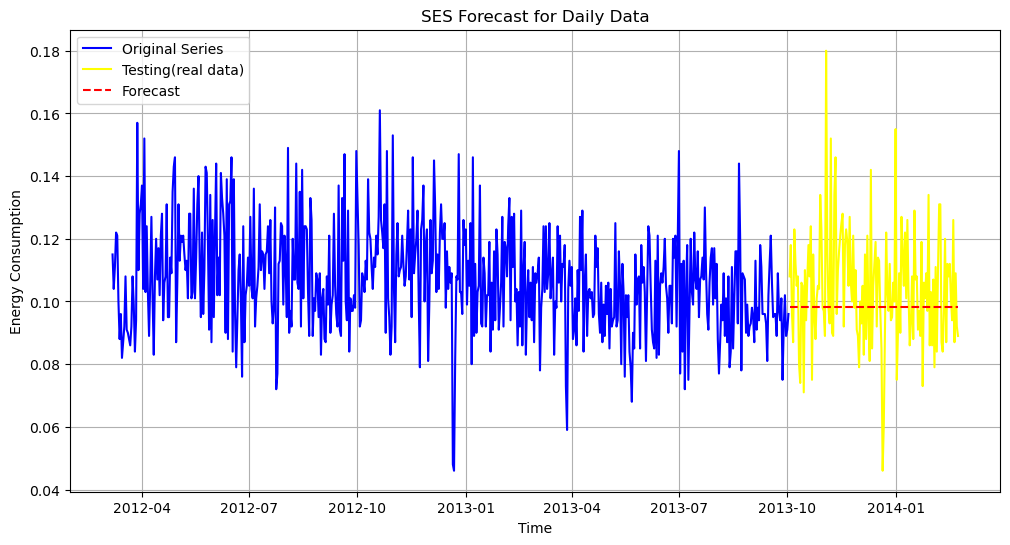

SES MSE: 0.0004


In [145]:
daily_series = daily_df.set_index(daily_df["timestamp"])
daily_series = daily_series['energy_consumption']
training_data = daily_series[:int(len(daily_series) * 0.8)]
test_data = daily_series[int(len(daily_series) * 0.8):]

print("Daily Data Forecasting using SES:")

fitted_values_ses, forecast_values_ses = forecast_and_plot_ses(training_data, test_data, title="SES Forecast for Daily Data")
mse_ses = mean_squared_error(test_data, forecast_values_ses)
print(f"SES MSE: {mse_ses:.4f}")

SES didn't capture trend or seasonality and stayed level throughout.

Daily Data Forecasting using DES:


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


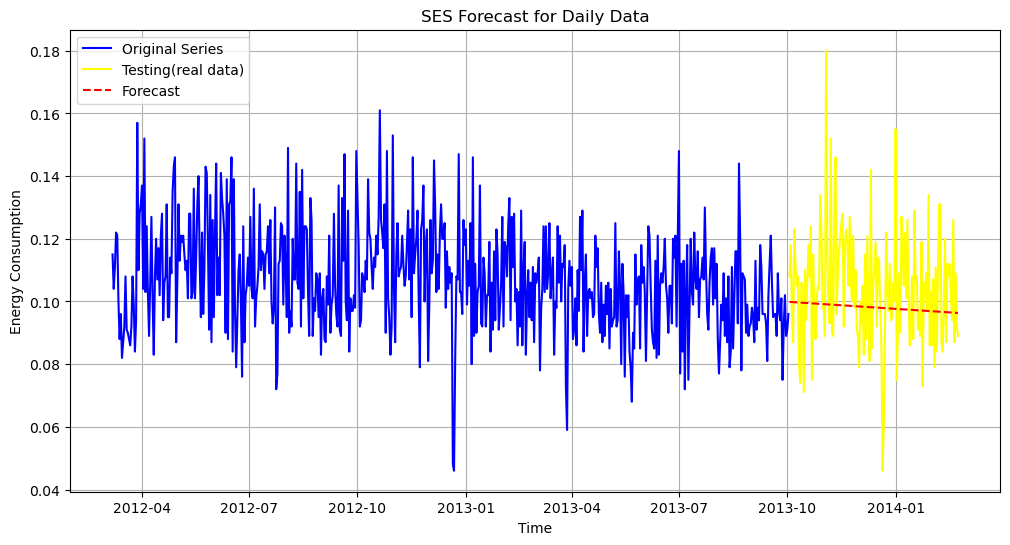

DES MSE: 0.0004


In [146]:
print("Daily Data Forecasting using DES:")

fitted_values_des, forecast_values_des = forecast_and_plot_des(training_data, test_data, title="SES Forecast for Daily Data")
mse_des = mean_squared_error(test_data, forecast_values_des)
print(f"DES MSE: {mse_des:.4f}")

DSE captures the trend - though not so much - but no seasonality.

Daily Data Forecasting using TES:


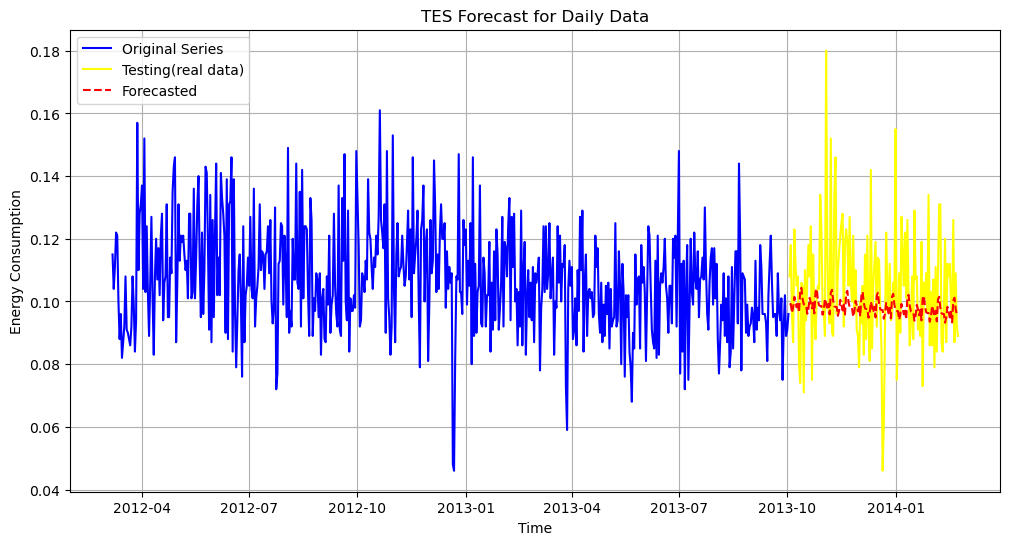

TES MSE: 0.0004


In [156]:
print("Daily Data Forecasting using TES:")
# assume biweekly seasonality
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(training_data, test_data, seasonal_periods=13, frequency='D',
                                                                title="TES Forecast for Daily Data")
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")

TES is much better as it captures both trend and seasonality. but the testing is far from realistic.

Daily Data Forecasting using TES:


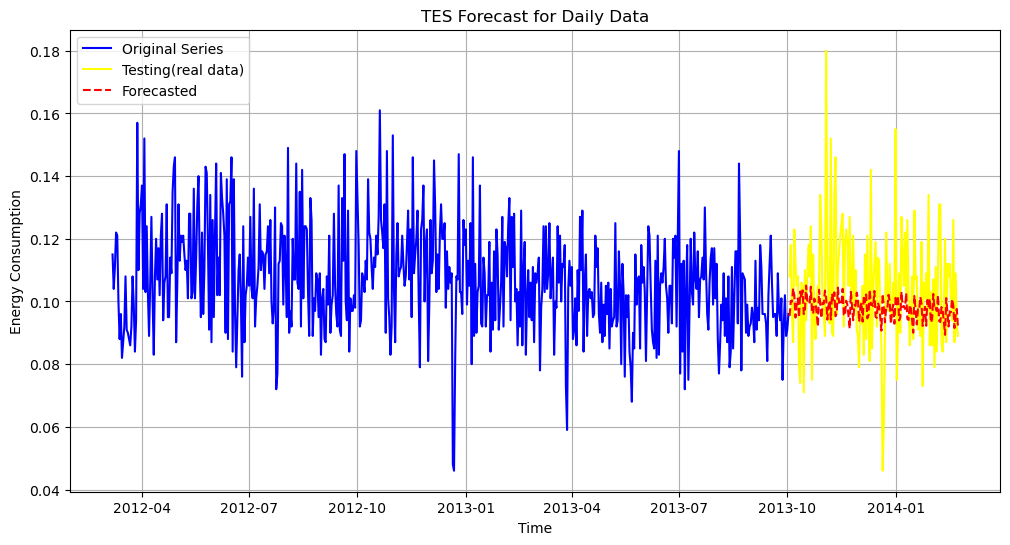

TES MSE: 0.0004


In [158]:
# Trying another seasonal period
print("Daily Data Forecasting using TES:")
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(training_data, test_data, seasonal_periods=27, frequency='D',
                                                                title="TES Forecast for Daily Data")
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")

4 weeks seasonality is better.

Weekly Data:

Weekly Data Forecasting using SES:


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


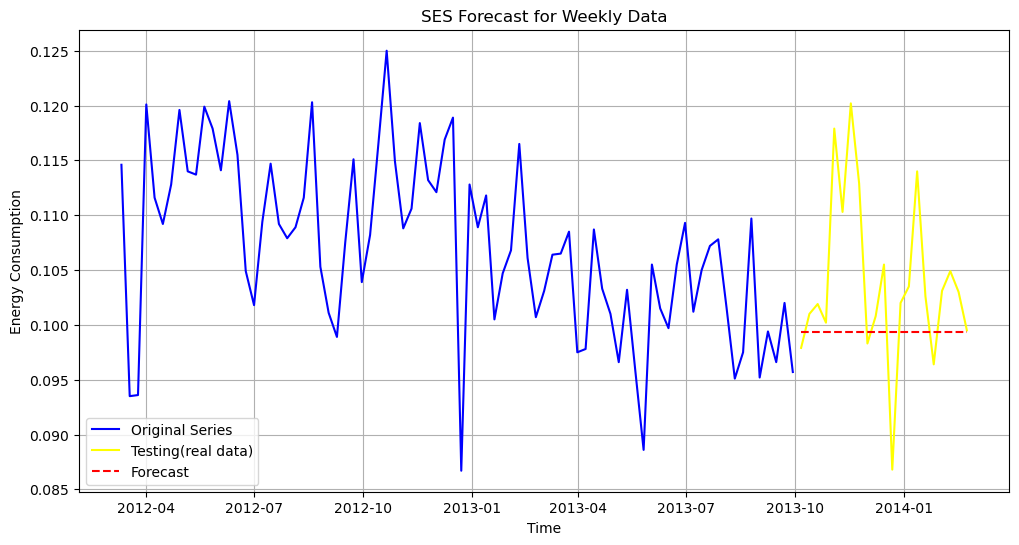

SES MSE: 0.0001


In [159]:
weekly_series = weekly_df.set_index(weekly_df["timestamp"])
weekly_series = weekly_series['energy_consumption']
training_data = weekly_series[:int(len(weekly_series) * 0.8)]
test_data = weekly_series[int(len(weekly_series) * 0.8):]

print("Weekly Data Forecasting using SES:")
fitted_values_ses, forecast_values_ses = forecast_and_plot_ses(training_data, test_data, title="SES Forecast for Weekly Data")
mse_ses = mean_squared_error(test_data, forecast_values_ses)
print(f"SES MSE: {mse_ses:.4f}")

as expected from SES, it didn't capture trend or seasonality and stayed level throughout.

Weekly Data Forecasting using DES:


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


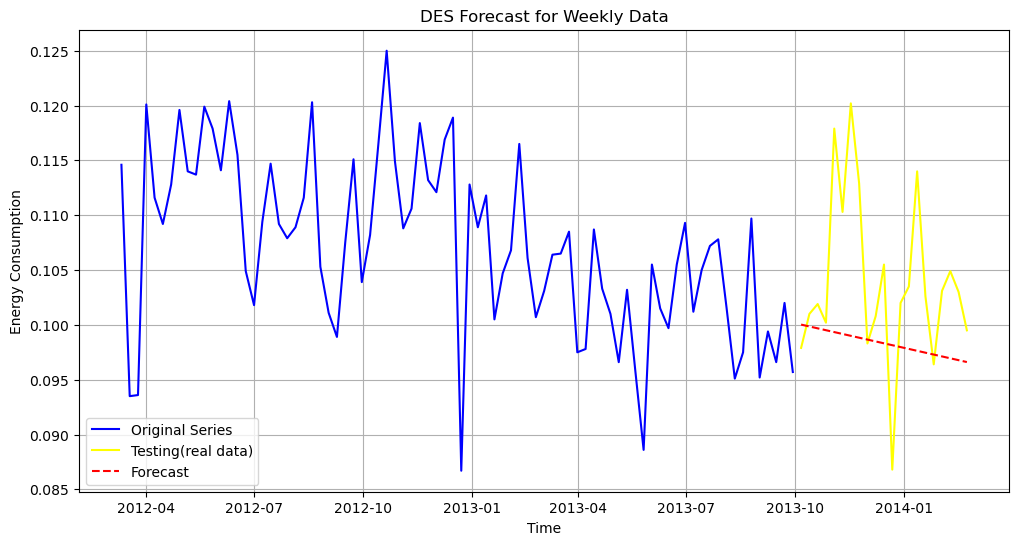

DES MSE: 0.0001


In [160]:
weekly_series = weekly_df.set_index(weekly_df["timestamp"])
weekly_series = weekly_series['energy_consumption']
training_data = weekly_series[:int(len(weekly_series) * 0.8)]
test_data = weekly_series[int(len(weekly_series) * 0.8):]

print("Weekly Data Forecasting using DES:")
fitted_values_des, forecast_values_des = forecast_and_plot_des(training_data, test_data, title="DES Forecast for Weekly Data")
mse_des = mean_squared_error(test_data, forecast_values_des)
print(f"DES MSE: {mse_des:.4f}")

Weekly Data Forecasting using TES, w/ 1-month seasonality:


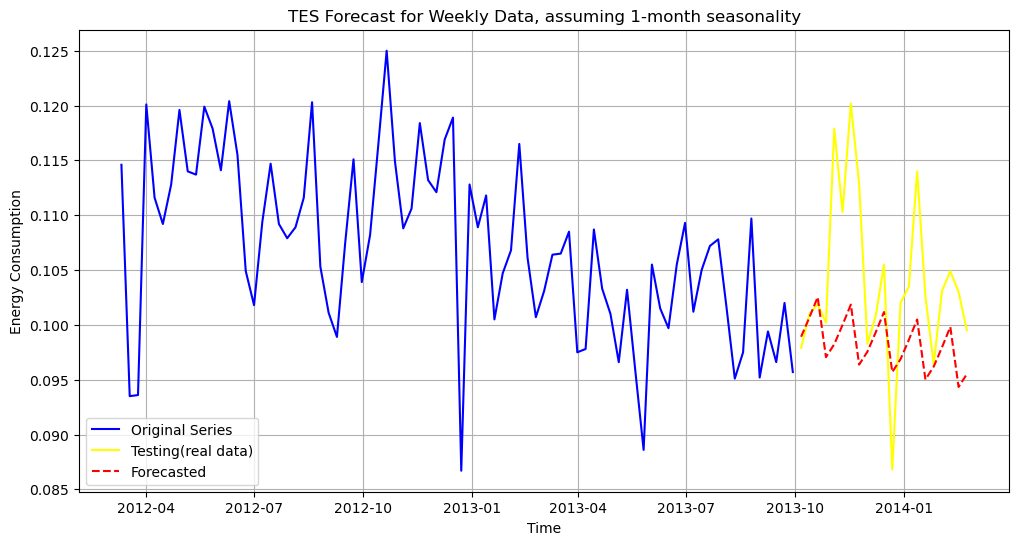

TES MSE: 0.0001
-----------------------------
Weekly Data Forecasting using TES, w/ 2-months seasonality:


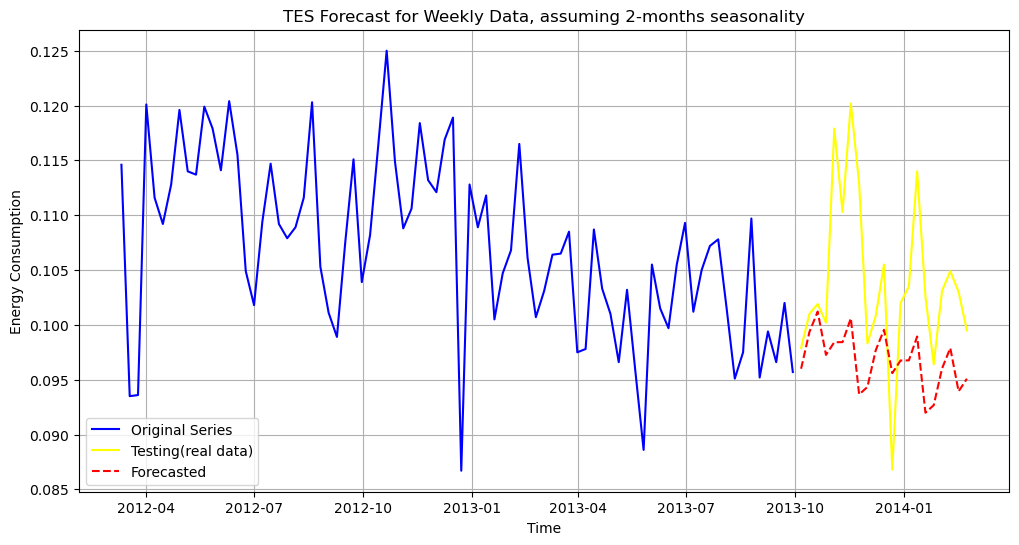

TES MSE: 0.0001
-----------------------------
Weekly Data Forecasting using TES, w/ 3-months seasonality:


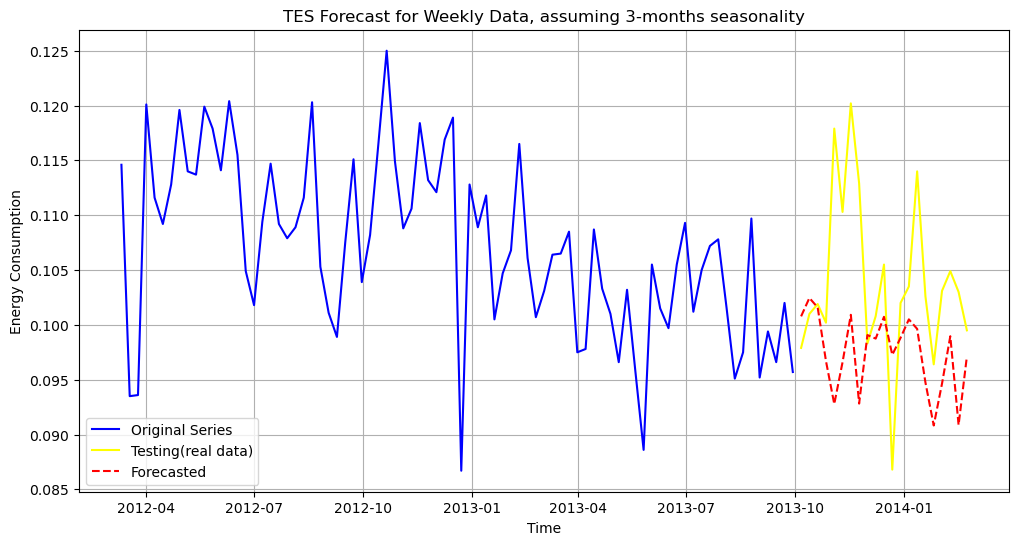

TES MSE: 0.0001
-----------------------------
Weekly Data Forecasting using TES, w/ 4-months seasonality:


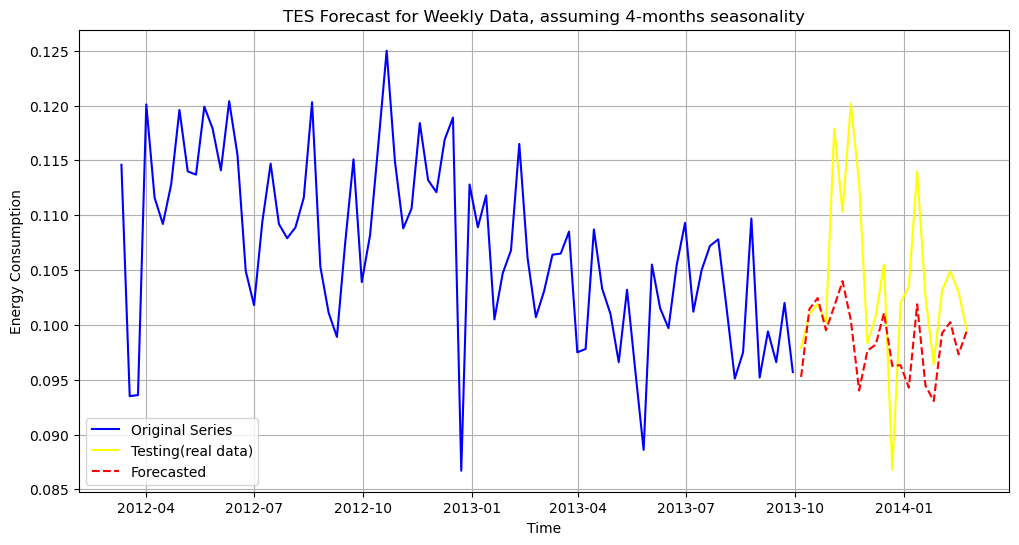

TES MSE: 0.0001


In [173]:
weekly_series = weekly_df.set_index(weekly_df["timestamp"])
weekly_series = weekly_series['energy_consumption']
training_data = weekly_series[:int(len(weekly_series) * 0.8)]
test_data = weekly_series[int(len(weekly_series) * 0.8):]

# Weekly Data Forecasting using TES, w/ 1-month seasonality (~4 weeks)
print("Weekly Data Forecasting using TES, w/ 1-month seasonality:")
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(
    training_data, test_data,
    seasonal_periods=4, frequency='W',
    title="TES Forecast for Weekly Data, assuming 1-month seasonality"
)
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")

# Weekly Data Forecasting using TES, w/ 2-months seasonality (~8 weeks)
print("-----------------------------\nWeekly Data Forecasting using TES, w/ 2-months seasonality:")
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(
    training_data, test_data,
    seasonal_periods=8, frequency='W',
    title="TES Forecast for Weekly Data, assuming 2-months seasonality"
)
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")

# Weekly Data Forecasting using TES, w/ 3-months seasonality (~12 weeks)
print("-----------------------------\nWeekly Data Forecasting using TES, w/ 3-months seasonality:")
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(
    training_data, test_data,
    seasonal_periods=12, frequency='W',
    title="TES Forecast for Weekly Data, assuming 3-months seasonality"
)
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")

# Weekly Data Forecasting using TES, w/ 4-months seasonality (~16 weeks)
print("-----------------------------\nWeekly Data Forecasting using TES, w/ 4-months seasonality:")
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(
    training_data, test_data,
    seasonal_periods=16, frequency='W',
    title="TES Forecast for Weekly Data, assuming 4-months seasonality"
)
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")


With seasonality 4 months, TES gets better but results may appear unrealistic. However the data has MSE of 0.0001 between prediction and testing which means that the plots may be misleading (refering to a domain expert in this case will help).

Monthly Data:

-----------------------------
Monthly Data Forecasting using SES:


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


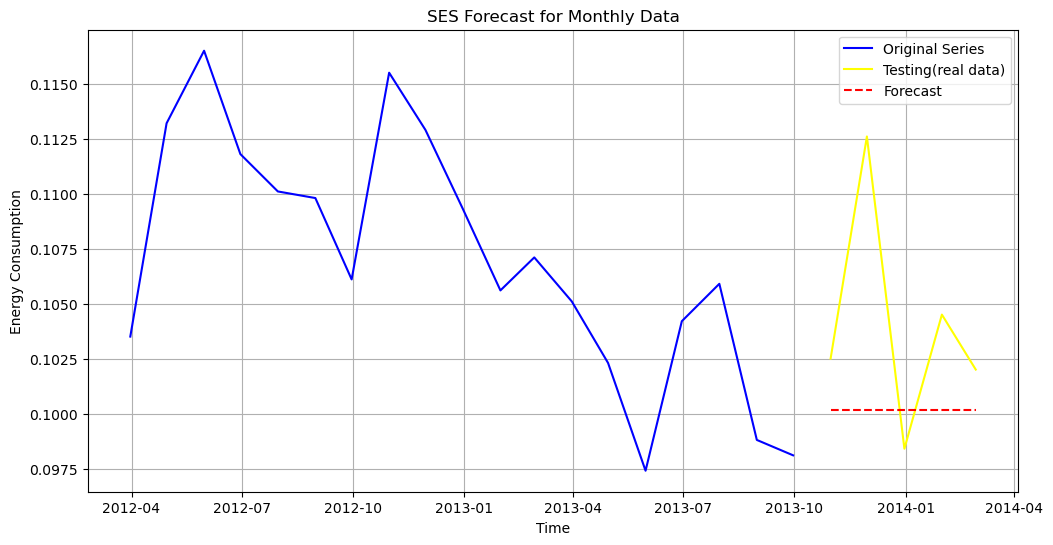

SES MSE: 0.0000


In [167]:
print("-----------------------------\nMonthly Data Forecasting using SES:")
monthly_series = monthly_df.set_index(monthly_df["timestamp"])
monthly_series = monthly_series['energy_consumption']
training_data = monthly_series[:int(len(monthly_series) * 0.8)]
test_data = monthly_series[int(len(monthly_series) * 0.8):]
fitted_values_ses, forecast_values_ses = forecast_and_plot_ses(training_data, test_data, title="SES Forecast for Monthly Data")
mse_ses = mean_squared_error(test_data, forecast_values_ses)
print(f"SES MSE: {mse_ses:.4f}")

-----------------------------
Monthly Data Forecasting using DES:


/home/hossam/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


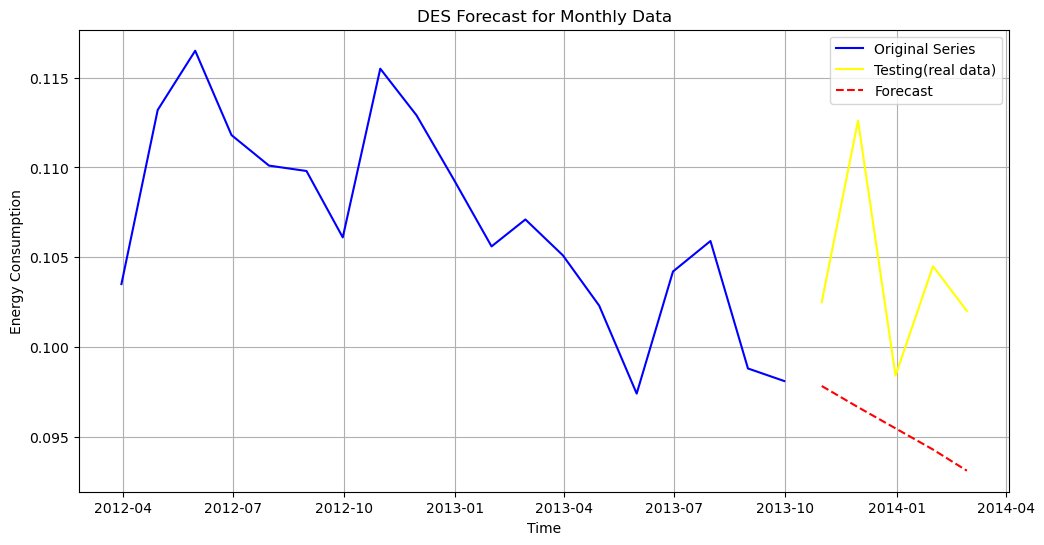

DES MSE: 0.0001


In [188]:
print("-----------------------------\nMonthly Data Forecasting using DES:")
monthly_series = monthly_df.set_index(monthly_df["timestamp"])
monthly_series = monthly_series['energy_consumption']
training_data = monthly_series[:int(len(monthly_series) * 0.8)]
test_data = monthly_series[int(len(monthly_series) * 0.8):]
fitted_values_des, forecast_values_des = forecast_and_plot_des(training_data, test_data, title="DES Forecast for Monthly Data")
mse_des = mean_squared_error(test_data, forecast_values_des)
print(f"DES MSE: {mse_des:.4f}")

-----------------------------
Monthly Data Forecasting using TES:


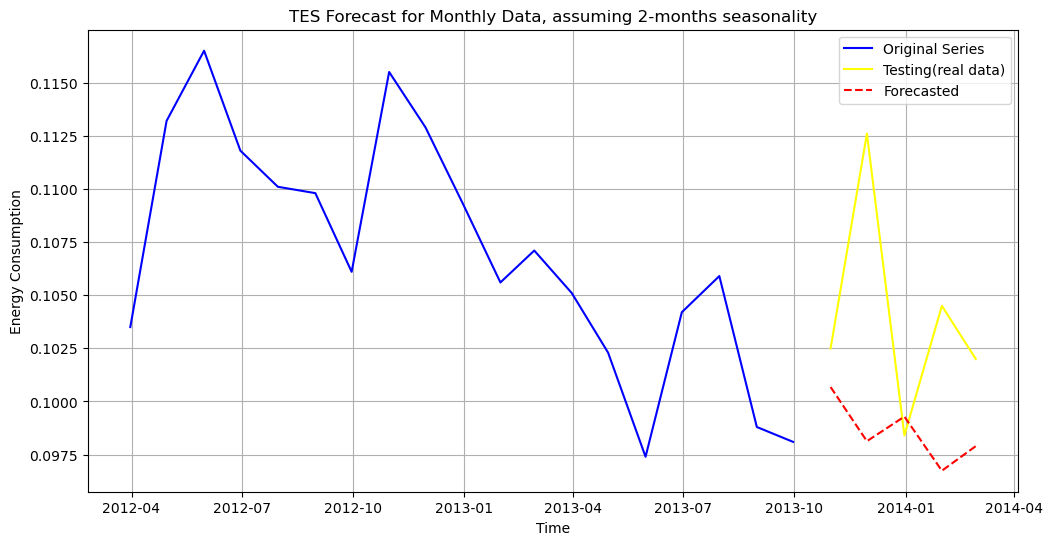

TES MSE: 0.0001


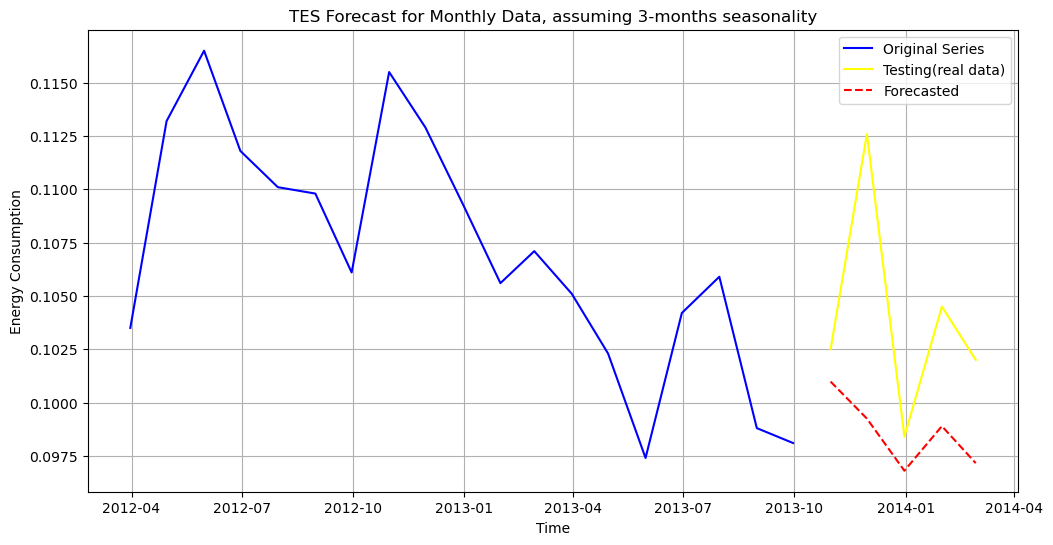

TES MSE: 0.0000
-----------------------------
Monthly Data Forecasting using TES, w/ 6-months seasonality:


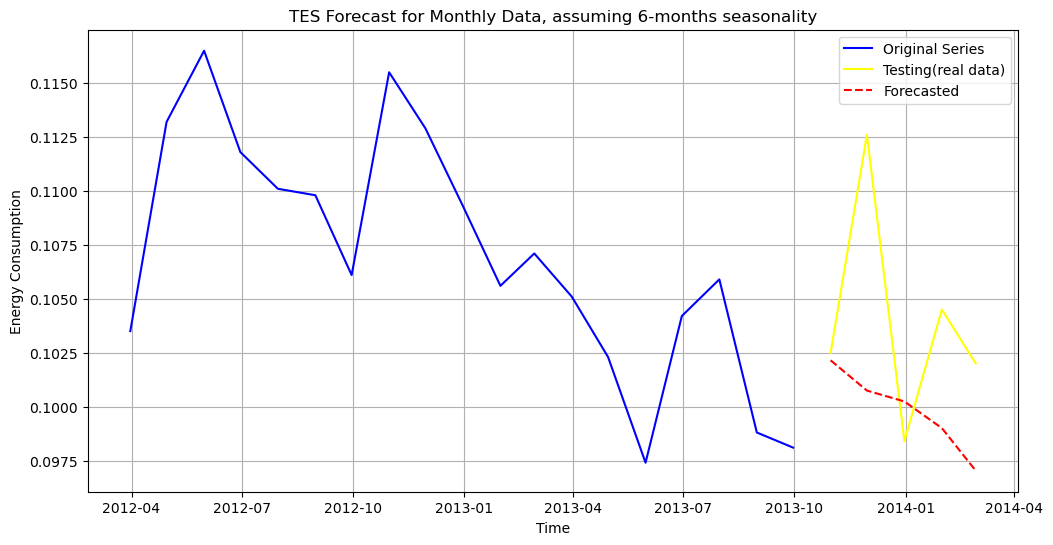

TES MSE: 0.0000
-----------------------------
Monthly Data Forecasting using TES, w/ 9-months seasonality:


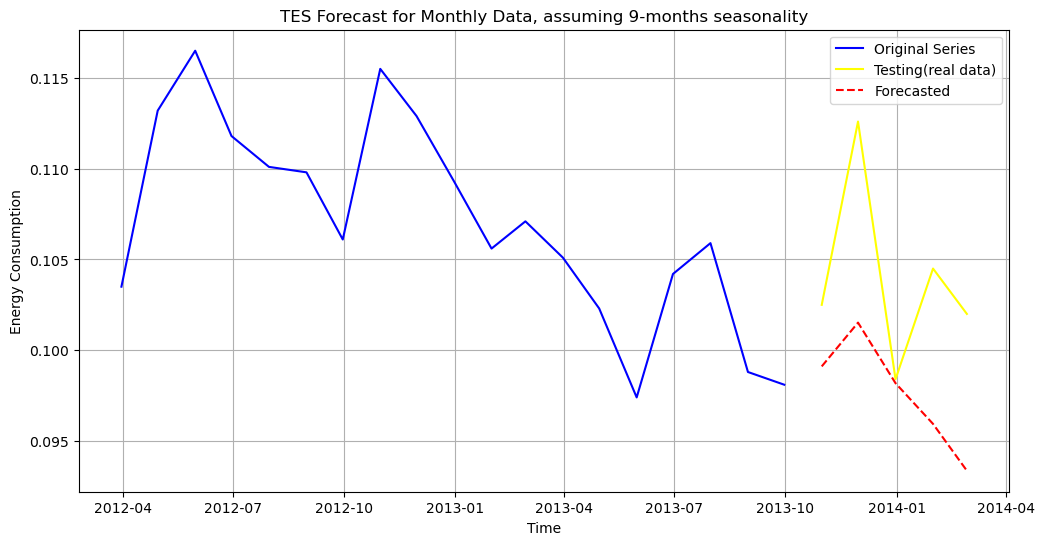

TES MSE: 0.0001


In [190]:
print("-----------------------------\nMonthly Data Forecasting using TES:")
# assume 2-months seasonality
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(training_data, test_data, seasonal_periods=2, frequency='M',
                                                                title="TES Forecast for Monthly Data, assuming 2-months seasonality")
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")
# Trying another seasonal period (3 months)

fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(training_data, test_data, frequency='M', seasonal_periods=3,
                                                                title="TES Forecast for Monthly Data, assuming 3-months seasonality")
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")

# Trying another seasonal period (6 months)
print("-----------------------------\nMonthly Data Forecasting using TES, w/ 6-months seasonality:")
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(training_data, test_data, seasonal_periods=6, frequency='M',
                                                                title="TES Forecast for Monthly Data, assuming 6-months seasonality")
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")

# Trying another seasonal period (9 months)
print("-----------------------------\nMonthly Data Forecasting using TES, w/ 9-months seasonality:")
fitted_values_tes, forecast_values_tes = forecast_and_plot_tes(training_data, test_data, seasonal_periods=9, frequency='M',
                                                                title="TES Forecast for Monthly Data, assuming 9-months seasonality")
mse_tes = mean_squared_error(test_data, forecast_values_tes)
print(f"TES MSE: {mse_tes:.4f}")

All results are not very good. However, the data has MSE of 0.0001 between prediction and testing again. From the plots, looks like a seasonality of 3 months is the best fit for the model as a parameter.